In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## **Installing Tranformers**

In [ ]:
!pip install transformers

## **Get Dataset**

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os

if not os.path.isdir("./gdrive/My Drive/result-training"):
  os.mkdir("./gdrive/My Drive/result-training")

## **Data Preprocessing**

In [ ]:
import pandas as pd

df = pd.read_csv("./gdrive/MyDrive/600-dataset1.csv", sep=";")
df2 = pd.read_csv("/content/gdrive/MyDrive/result.csv", sep=",")
df3 = pd.read_csv("/content/gdrive/MyDrive/hoax.csv", sep=",")

df2 = df2.drop(['url','judul'], axis=1)
df3 = df3.drop(['url','judul'], axis=1)

df = df.append(df2, ignore_index=True)
df = df.append(df3, ignore_index=True)

df["labels"] = df["tagging"]

df['tagging'] = pd.Categorical(df.tagging).codes

df = df.dropna()

df.describe

<bound method NDFrame.describe of                                                  berita  tagging labels
0     Jakarta, Di jejaring sosial, banyak beredar in...        1  Valid
1     Isu bahwa ikan lele mengandung sel kanker di j...        1  Valid
2     Bagi penikmat kuliner dengan bahan dasar ikan ...        1  Valid
3     Ikan lele merupakan salah satu makanan favorit...        1  Valid
4     Ikan lele merupakan bahan makanan yang cukup p...        1  Valid
...                                                 ...      ...    ...
1759  “Inalilahi wainailaihi rojiunTelah meninggal.....        0   Hoax
1760  “Mudah-mudahan program yang saya adakan ini bi...        0   Hoax
1761  pendaftaran secara online di portal ke: bit[do...        0   Hoax
1763              “Abis bubarin FPI kita joget gaeesss”        0   Hoax
1764        “Hari Ini Sudah Ngecrot Berapa Kali Zon???”        0   Hoax

[1621 rows x 3 columns]>

In [ ]:
df.berita[0]

'Jakarta, Di jejaring sosial, banyak beredar informasi yang menyebut lele sebagai\nikan paling jorok. Dalam sesuap daging ikan lele, terkandung 3000 sel kanker. Benarkah?\nJulukan sebagai ikan paling jorok merujuk pada sifat lele yang doyan mengonsumsi\nsegala jenis limbah di perairan. Bahkan sebuah artikel yang cukup viral di internet\nmenyebutkan kotoran manusia juga dijadikan pakan pada sebuah budidaya lele di Kota Haikou, China.\nSementara itu di habitat aslinya, lele atau catfish juga dikenal sebagai spesies ikan yang\nsangat tangguh. Ikan ini dilengkapi alat pernapasan tambahan berupa labirin,\nsehingga mampu bertahan hidup dalam kondisi perairan berlumpur atau bahkan tercemar.\nAgaknya, fakta inilah yang memunculkan dugaan soal akumulasi racun karsinogen (penyebab kanker) di tubuh ikan lele.\nUntungnya, ikan lele yang beredar di pasaran bukan berasal dari alam liar.\nLele banyak dibudidayakan di kolam-kolam, yang mestinya bisa dikendalikan agar bebas dari pencemaran.\nPakan yang

In [ ]:
df.berita[0][0]

'J'

In [ ]:
df.tagging.value_counts()

0    885
1    736
Name: tagging, dtype: int64

In [ ]:
berita = df.berita.values
labels = df.tagging.values

### Punctuation, Number Remover and Case Converter

In [ ]:
import re

def preprocess_text(sentence):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence.lower()

### Truncating Teks

In [ ]:
berita_short = []

In [ ]:
for index,sentences in enumerate(berita):
  sentences = preprocess_text(sentences)
  temp_word = sentences.split()

  length = len(temp_word)

  if(length > 512):
    #temp_word = temp_word[:129] + temp_word[length-383: length+1]
    temp_word = temp_word[:512]
    #temp_word = temp_word[length-512: length+1]

  berita_short.append(temp_word)

In [ ]:
#berita_short[0][len(berita_short[0]) - 20:len(berita_short[0])]

In [ ]:
#len(berita_short[3])

## Data Processing

In [ ]:
#len(berita[0])

In [ ]:
#berita_short[0]

In [ ]:
#' '.join(berita_short[0])

In [ ]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, AdamW, RobertaForSequenceClassification,get_linear_schedule_with_warmup
import torch

#model_name ='indobenchmark/indobert-base-p1'
model_name ="cahya/gpt2-small-indonesian-522M"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

input_id = [tokenizer.encode(sent, padding='max_length', truncation=True, max_length=512, ) for sent in berita_short]

In [ ]:
attention_masks = [[float(i>0) for i in seq] for seq in input_id]

In [ ]:
len(input_id[0])

512

In [ ]:
#attention_masks
#input_id

In [ ]:
#input_id[3][len(input_id[3])-1]

### Split Data

In [ ]:
import torch

torch.is_tensor(input_id)

False

In [ ]:
from sklearn.model_selection import train_test_split

# Split train and validation with 10:1 ratio
train_inputs, validation_input, train_labels, validation_labels  = train_test_split(input_id, labels,random_state=32, test_size=0.1)
# We only need to split attention mask into 2 variable, labels is not needed for this.
train_masks, validation_masks, label_mask,_  = train_test_split(attention_masks, labels,random_state=32, test_size=0.1)

# From the train_input, split again to train and prediction with 10:1 ratio
train_inputs, prediction_input, train_labels, prediction_labels  = train_test_split(train_inputs, train_labels,random_state=3, test_size=0.2)
train_masks, prediction_masks, _,_  = train_test_split(train_masks, label_mask,random_state=3, test_size=0.2)

In [ ]:
#[len(i) for i in train_inputs]

In [ ]:
#import torch

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_input)
prediction_input = torch.tensor(prediction_input)

train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
prediction_labels = torch.tensor(prediction_labels, dtype=torch.long)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
prediction_masks = torch.tensor(prediction_masks)

In [ ]:
#train_labels

In [ ]:
#train_inputs

In [ ]:
import torch

torch.is_tensor(train_inputs[0])

True

In [ ]:
train_inputs.size

<function Tensor.size>

In [ ]:
train_inputs[0].size

<function Tensor.size>

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 8

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

prediction_data = TensorDataset(prediction_input, prediction_masks, prediction_labels)
prediction_sampler = RandomSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


### Models

In [ ]:
model = GPT2ForSequenceClassification.from_pretrained(
    model_name, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
    #hidden_dropout_prob = 0.3,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id

model.to(device)

Some weights of the model checkpoint at cahya/gpt2-small-indonesian-522M were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at cahya/gpt2-small-indonesian-522M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=Fal

In [ ]:
params = list(model.named_parameters())

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

transformer.h.11.mlp.c_proj.bias                              (768,)
transformer.ln_f.weight                                       (768,)
transformer.ln_f.bias                                         (768,)
score.weight                                                (2, 768)


In [ ]:
optimizer = AdamW(model.parameters(), lr = 2e-5, correct_bias=False)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 2

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
train_loss_values = []
eval_loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs.loss

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    train_loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None,
                            labels=b_labels,
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        loss = outputs.loss

        eval_loss += loss.item()

        # Track the number of batches
        nb_eval_steps += 1

    avg_eval_loss = eval_loss / len(validation_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    eval_loss_values.append(avg_eval_loss)

        
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print(" validation loss : {:.2f}".format(avg_eval_loss))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    146.    Elapsed: 0:00:38.
  Batch    80  of    146.    Elapsed: 0:01:15.
  Batch   120  of    146.    Elapsed: 0:01:51.

  Average training loss: 0.61
  Training epcoh took: 0:02:15

Running Validation...
  Accuracy: 0.85
 validation loss : 0.44
  Validation took: 0:00:07

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    146.    Elapsed: 0:00:37.
  Batch    80  of    146.    Elapsed: 0:01:14.
  Batch   120  of    146.    Elapsed: 0:01:50.

  Average training loss: 0.28
  Training epcoh took: 0:02:14

Running Validation...
  Accuracy: 0.89
 validation loss : 0.25
  Validation took: 0:00:07

Training complete!


In [ ]:
eval_loss_values

[0.43637673893854734, 0.24766642351945242]

In [ ]:
train_loss_values

[0.6094217959357655, 0.2814133783008214]

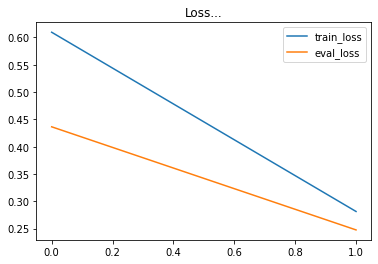

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_values, label="train_loss")
plt.plot(eval_loss_values, label="eval_loss")
plt.title('Loss...')
plt.legend(loc = 'best')
plt.show()

In [ ]:
# Prediction on test set

#print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

test_acc = 0.0
test_f1 = 0.0

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labelstest
  predictions.append(logits)
  true_labels.append(label_ids)

  

In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

print(classification_report(flat_predictions, flat_true_labels))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       145
           1       0.85      0.80      0.83       147

    accuracy                           0.83       292
   macro avg       0.83      0.83      0.83       292
weighted avg       0.83      0.83      0.83       292



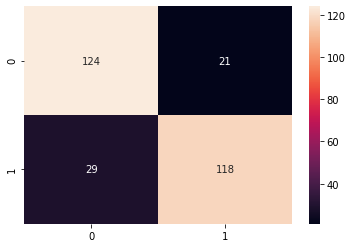

In [ ]:
import seaborn as sns

cf_matrix = confusion_matrix(flat_predictions, flat_true_labels)
plt.figure()
sns.heatmap(cf_matrix, annot=True, fmt='d')